# Load env
Set up the environment `challenge_py_env` as described in https://github.com/Teichlab/COVID-19_Challenge_Study and activate it to run the below code.

In [1]:
import cell2tcr
import numpy as np
import pandas as pd
import scanpy as sc
import pickle
import collections
import re
import os
import scipy.stats as stats
from statannotations.Annotator import Annotator

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
savedir = '/nfs/team205/ld21/public/figures/public_challenge_figures/'
plt.style.use('seaborn-white')
matplotlib.rcParams['savefig.transparent'] = True
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['pdf.fonttype'] = 42

sc.settings.verbosity = 3  
sc.settings.set_figure_params(facecolor='white', color_map='viridis')

/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_4816/171451534.py:17: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


# Integration of public data

In [2]:
# this is too big to load and do operations on 
# public_adata = sc.read_h5ad('/nfs/team205/ld21/public/h5ad_by_study/public_combined.h5ad')
# public_adata
p_adata = sc.read_h5ad('/nfs/team205/ld21/public/tcr_only_20latent_drop_low_batches.h5ad')

# append celltypist results
with open('/nfs/team205/ld21/public/run_celltypist/run_celltypist_29092022/celltypist_predictions.pkl', 'rb') as f:
    predicted_labels, _, _ = pickle.load(f)

p_adata.obs['celltypist'] = predicted_labels.predicted_labels
p_adata.obs['celltypist_majority'] = predicted_labels.majority_voting
p_adata

AnnData object with n_obs × n_vars = 946584 × 36522
    obs: 'patient_id', 'sample_id', 'days_since_onset_symptoms', 'age', 'sex', 'severity', 'disease_status', 'cell_type', 'original_cell_type_annotation', 'cell_cycle_phase', 'g2m_score', 's_score', 'ifn_stim_score', 'study', 'CDR3b', 'TRBV', 'TRBD', 'TRBJ', 'CDR3a', 'TRAV', 'TRAJ', 'days_since_onset_symptoms_num', '_scvi_batch', '_scvi_labels', 'Activated', 'celltypist', 'celltypist_majority'
    uns: 'Activated_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors'
    obsm: 'X_mde', 'X_mde_2', 'X_scVI', 'X_scVI_2', '_scvi_extra_categorical_covs'

In [3]:
celltypist_activated = p_adata[p_adata.obs.celltypist.str.contains('Activated')].obs.celltypist.unique().to_list()
celltypist_activated.remove('T MAI Activated')

with open('/nfs/team205/ld21/public/tcr_only_20latent_drop_low_batches_scVI_UMAP_NNs.pkl', 'rb') as f:
    scVI_umap, scVI_dist, scVI_con = pickle.load(f)
p_adata.obsm['X_umap'] = scVI_umap

annotation = pd.read_csv('/nfs/team205/ld21/challenge/data/challenge_pbmc_annotation_01112022.csv', index_col=0)
cell_state_color_dict = annotation[['cell_state', 'cell_state_color']].drop_duplicates().set_index('cell_state').cell_state_color.to_dict()
p_adata.uns['celltypist_colors'] = p_adata.obs.celltypist.cat.categories.map(cell_state_color_dict).copy()
p_adata.uns['celltypist_colors'] = list(p_adata.uns['celltypist_colors'])
for ind, c in enumerate(p_adata.uns['celltypist_colors']):
    try: 
        if np.isnan(c): # nans need to be removed, else scanpy overwrites all colors
            p_adata.uns['celltypist_colors'][ind] = 'grey'
    except: continue

## Fig 4a

/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


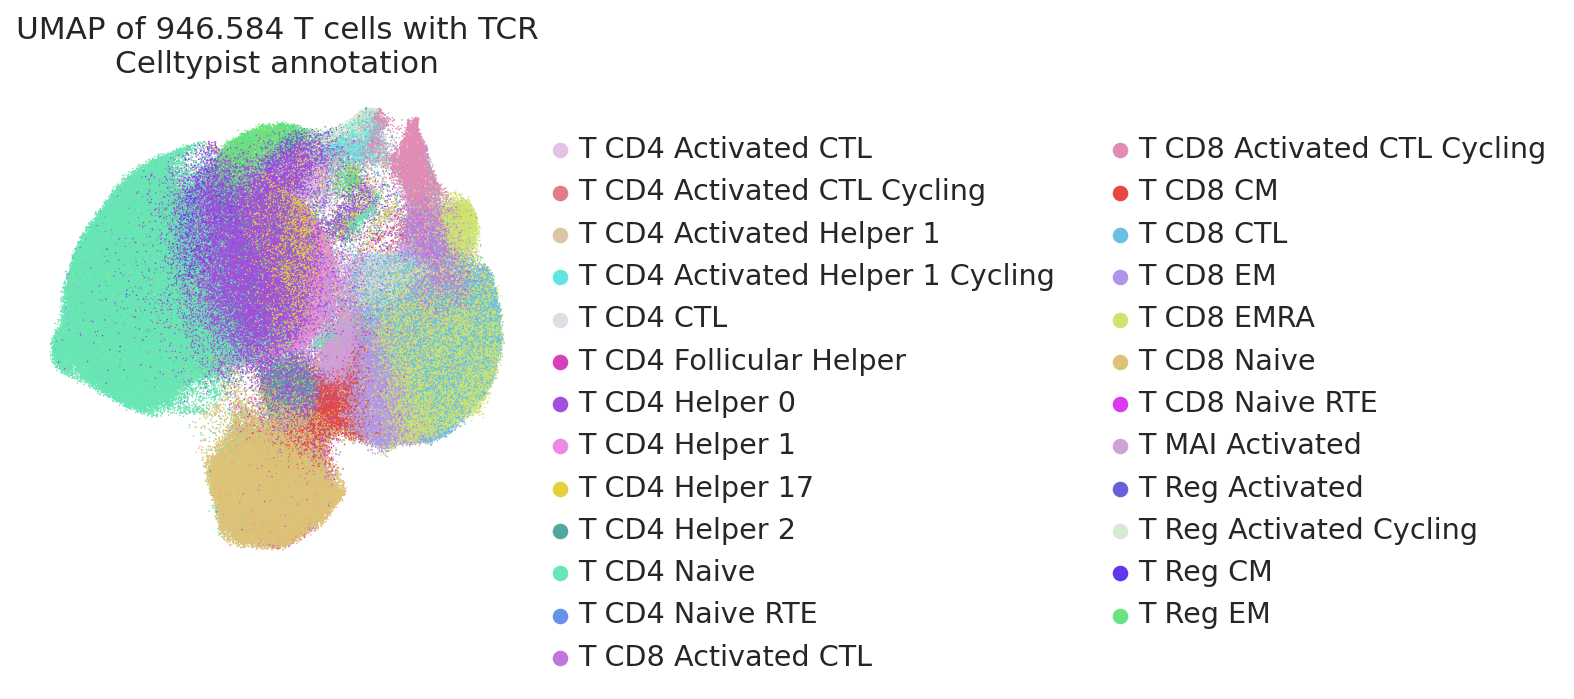

In [4]:
f = [i for i in p_adata.obs.celltypist.value_counts()[:20].keys().values if not 'IFN' in i and not 'Monocyte' in i]
for i in celltypist_activated:
    f.append(i)
g = sc.pl.umap(
    p_adata,
    na_in_legend=False, na_color='w', 
    groups = f,
    color='celltypist',
    size=2, show=False, frameon=False
)
g.set_title('UMAP of 946.584 T cells with TCR\nCelltypist annotation')
g.legend(ncol=2, bbox_to_anchor=(1, 0.95))
# plt.savefig(savedir+'public_UMAP.pdf')

# Enrichment of activated T cells in COVID-19 samples

In [5]:
severity_dict = {
    'moderate':'moderate',
    'severe':'severe', 
    'control':'control',
    'mild':'mild',
    'critical':'severe', 
    'healthy':'control', 
    'asymptomatic':'asymptomatic', 
    'mild/moderate':'mild', 
    'severe/critical':'severe'
}
p_adata.obs['severity_std'] = p_adata.obs.severity.map(severity_dict)
df = sc.get.obs_df(p_adata, keys=['sample_id','study','days_since_onset_symptoms_num', 'celltypist_majority','celltypist','disease_status', 'age', 'severity', 'severity_std', 'sex'])

# ignore MAIT for now 
# df.loc[df.celltypist_majority=='T MAI Activated','celltypist_majority'] = 'T MAI'
# df.loc[df.celltypist=='T MAI Activated','celltypist'] = 'T MAI'

# ignore anything besides covid, convalescent, healthy
df = df[df.disease_status.isin(['COVID-19','healthy','convalescence'])]

# a quick rule to make all age into this form :
# 60 for anything thats 60-69
def get_age_num(row):
    age_num = -1
    if row.age == 'unknown':
        return np.nan
    if row.age == '>90':
        return 90
    # if number
    try:
        age = float(row.age)
        for i in range(11):
            if age < i*10:
                age_num = (i-1)*10
                break
    # if age bracket
    except:
        age_str = row.age
        for i in range(1, 11):
            if (str(i*10 + 1) in age_str) or (str(i*10 + 9) in age_str):
                age_num = i*10
                break
    finally:
        return age_num

df['age_num'] = df.apply(get_age_num, axis=1)

# per sample df
df_samples = df.drop_duplicates('sample_id')

severity_dict = dict(zip(
    ['healthy', 'control', 'asymptomatic', 'mild', 'mild/moderate', 'moderate', 'severe', 'severe/critical', 'critical'],
    [0,0,1,2,2.5,3,4,4.5,5]))
df_samples['severity_num'] = df_samples.severity.map(severity_dict)

severity_reduced_dict = dict(zip(
    ['healthy', 'control', 'asymptomatic', 'mild', 'mild/moderate', 'moderate', 'severe', 'severe/critical', 'critical'],
    [0,0,1,2,2,2,3,3,3]))
df_samples['severity_reduced_num'] = df_samples.severity.map(severity_reduced_dict)
df_samples['severity_reduced_str'] = df_samples.severity_reduced_num.map({0:'Healthy',1:'Asymptomatic',2:'Mild',3:'Severe'})

def get_frac_activated(row, majority=True):
        df_sub = df[df.sample_id==row.sample_id]
        if majority:
            return df_sub.celltypist_majority.isin(celltypist_activated).sum()/df_sub.shape[0]
        else:
            return df_sub.celltypist.isin(celltypist_activated).sum()/df_sub.shape[0]

df_samples['frac_activated'] = df_samples.apply(get_frac_activated, axis=1)
df_samples['frac_activated_nonmajority'] = df_samples.apply(get_frac_activated, axis=1, majority=False)
df_samples['severity_reduced_str'] = df_samples['severity_reduced_str'].astype(str)

def get_age_reduced(row):
    if row.age_num < 31:
        return '0-30'
    elif row.age_num < 51:
        return '31-50'
    else:
        return '51+'

df_samples['age_reduced'] = df_samples.apply(get_age_reduced, axis=1)
df_samples.head()

/tmp/ipykernel_4616/4089259904.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['severity_num'] = df_samples.severity.map(severity_dict)
/tmp/ipykernel_4616/4089259904.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_samples['severity_reduced_num'] = df_samples.severity.map(severity_reduced_dict)
/tmp/ipykernel_4616/4089259904.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,sample_id,study,days_since_onset_symptoms_num,celltypist_majority,celltypist,disease_status,age,severity,severity_std,sex,age_num,severity_num,severity_reduced_num,severity_reduced_str,frac_activated,frac_activated_nonmajority,age_reduced
AAACCTGAGAAACCTA-MH9179824,MH9179824,Stephenson,8.0,T CD8 EMRA,T CD8 EMRA,COVID-19,"(50, 59]",moderate,moderate,F,50.0,3.0,2,Mild,0.0,0.004977,31-50
AAACCTGCAGTAGAGC-MH9143327,MH9143327,Stephenson,8.0,T CD8 EMRA,T CD8 EM,COVID-19,"(50, 59]",moderate,moderate,M,50.0,3.0,2,Mild,0.0,0.004983,31-50
AAACCTGCAGGTGGAT-MH9143326,MH9143326,Stephenson,22.0,T CD8 EMRA,T CD4 CTL,COVID-19,"(50, 59]",moderate,moderate,M,50.0,3.0,2,Mild,0.0,0.028112,31-50
AAACCTGCACAGGAGT-MH9143325,MH9143325,Stephenson,7.0,T CD4 Naive IFN stim,T CD4 Naive IFN stim,COVID-19,"(80, 89]",severe,severe,F,80.0,4.0,3,Severe,0.0,0.001846,51+
AAACGGGGTTAAGACA-MH9143320,MH9143320,Stephenson,15.0,T CD8 EM,T CD8 EMRA,COVID-19,"(50, 59]",severe,severe,F,50.0,4.0,3,Severe,0.0,0.004619,31-50


## Fig 4b

healthy vs. COVID-19: Mann-Whitney-Wilcoxon test two-sided, P_val:4.390e-05 U_stat=8.423e+03
healthy vs. convalescence: Mann-Whitney-Wilcoxon test two-sided, P_val:1.115e-09 U_stat=1.926e+03


/tmp/ipykernel_4616/4251883090.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


Text(0.5, 1.0, 'Fraction of Activated T cells by disease status')

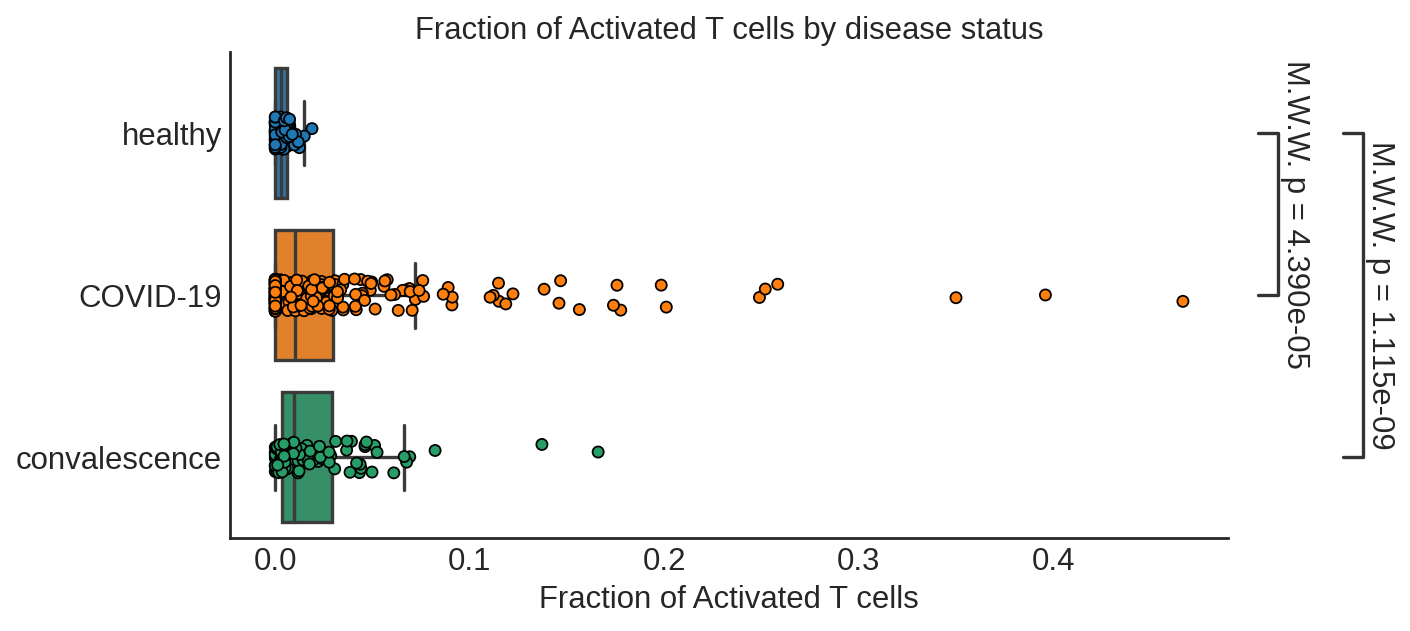

In [6]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-white')
ax = sns.boxplot(data=df_samples,  order=['healthy','COVID-19','convalescence'], showfliers=False,  y='disease_status', x='frac_activated',)
sns.stripplot(data=df_samples, y='disease_status', x='frac_activated', order=['healthy','COVID-19','convalescence'], edgecolor='k', linewidth=0.8)
annotator = Annotator(ax, [('healthy', 'COVID-19'),('healthy', 'convalescence')], data=df_samples, order=['healthy','COVID-19','convalescence'], orient='h',  y='disease_status', x='frac_activated',)
annotator.configure(test='Mann-Whitney', text_format='full', loc='outside')
annotator.apply_and_annotate()
plt.ylabel(None)
plt.xlabel('Fraction of Activated T cells')
plt.title('Fraction of Activated T cells by disease status')
# plt.savefig(savedir+'fraction_activated_by_disease_status_box_pvalue_star')

## Fig 4c

/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


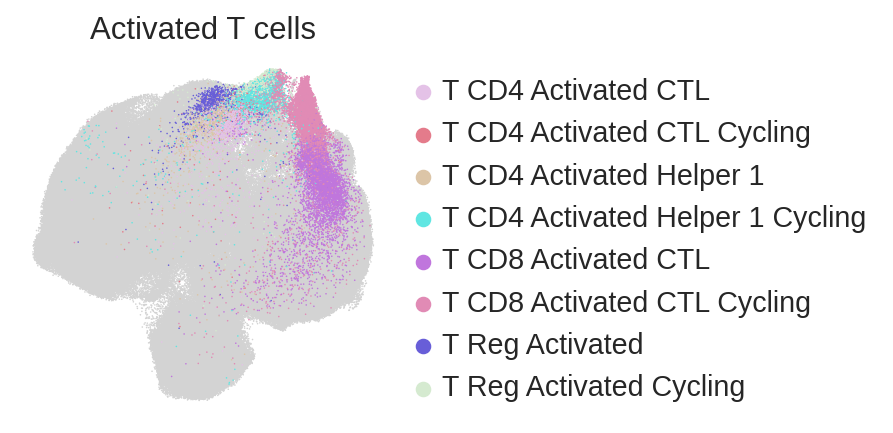

In [7]:
matplotlib.rcParams['figure.figsize'] = (3,3)
g = sc.pl.umap(
    p_adata,
    na_in_legend=False, na_color='lightgrey', 
    groups = celltypist_activated,
    color='celltypist',
    size=2, show=False, frameon=False,
)
g.set_title('Activated T cells')
g.legend(ncol=1, bbox_to_anchor=(1, 1))
# plt.savefig(savedir+'public_UMAP_activated.pdf', transparent=True)

# GEX and VDJ integration of public and COVID-19 challenge data

In [2]:
# load Public data
p_adata = sc.read_h5ad('/nfs/team205/ld21/public/tcr_only_20latent_drop_low_batches.h5ad')

# append celltypist results
with open('/nfs/team205/ld21/public/run_celltypist/run_celltypist_29092022/celltypist_predictions.pkl', 'rb') as f:
    predicted_labels, _, _ = pickle.load(f)

p_adata.obs['celltypist'] = predicted_labels.predicted_labels
p_adata.obs['celltypist_majority'] = predicted_labels.majority_voting

# make TCRdist compatible
for name, chain in zip(['subject','cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene'],
                       ['patient_id', 'CDR3b', 'TRBV', 'TRBJ', 'CDR3a', 'TRAV','TRAJ']):
    p_adata.obs[name] = p_adata.obs[chain]

# drop incomplete TCRs
p_adata = p_adata[(p_adata.obs.cdr3_b_aa.astype(str)!='nan')&(p_adata.obs.cdr3_a_aa.astype(str)!='nan')].copy()
p_adata = p_adata[(p_adata.obs.cdr3_b_aa.astype(str)!='None')&(p_adata.obs.cdr3_a_aa.astype(str)!='None')].copy()

# add generic allele suffix for TCRdist compatibility
for genes in ['v_b_gene', 'j_b_gene', 'v_a_gene', 'j_a_gene']:
    p_adata.obs[genes] = p_adata.obs[genes].astype(str) + '*01'
print('Loaded p_adata', p_adata.shape)

# load Challenge data
c_adata = sc.read_h5ad('/nfs/team205/ld21/challenge/data/df_pbmc_v1_TCR.h5ad')

# make TCRdist compatible
for name, chain in zip(['subject','count', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene'],
                       ['patient_id', 'tcr_clonotype_n', 'IR_VDJ_1_cdr3_tcr', 'IR_VDJ_1_v_gene_tcr', 'IR_VDJ_1_j_gene_tcr', 'IR_VJ_1_cdr3_tcr', 'IR_VJ_1_v_gene_tcr','IR_VJ_1_j_gene_tcr']):
    c_adata.obs[name] = c_adata.obs[chain]
    
# drop incomplete TCRs
c_adata = c_adata[(c_adata.obs.cdr3_b_aa.astype(str)!='nan')&(c_adata.obs.cdr3_a_aa.astype(str)!='nan')].copy()
c_adata = c_adata[(c_adata.obs.cdr3_b_aa.astype(str)!='None')&(c_adata.obs.cdr3_a_aa.astype(str)!='None')].copy()

# add generic allele suffix for TCRdist compatibility
for genes in ['v_b_gene', 'j_b_gene', 'v_a_gene', 'j_a_gene']:
    c_adata.obs[genes] = c_adata.obs[genes].astype(str) + '*01'
print('Loaded c_adata', c_adata.shape)

# Challenge annotation 01.11.2022
annotation = pd.read_csv('/nfs/team205/ld21/challenge/data/challenge_pbmc_annotation_01112022.csv', index_col=0)
c_adata.obs['annot_0111'] = annotation.cell_state.loc[c_adata.obs_names]

# consider these types as activated T cells
celltypist_activated = list(annotation[annotation.cell_state.str.contains('Activated')].cell_state.unique())
celltypist_activated.remove('T MAI Activated')
celltypist_activated.remove('Monocyte CD14+ Activated')

Loaded p_adata (850581, 36522)
Loaded c_adata (112104, 33559)


In [3]:
df_clone = c_adata[(c_adata.obs.annot_0111.isin(celltypist_activated))&(c_adata.obs.covid_status=='Infected')].obs.copy()
df_clone['celltypist_majority'] = df_clone.annot_0111.copy()
df_clone['celltypist'] = df_clone.annot_0111.copy() # same for Challenge data
df_clone['study'] = 'Challenge'

# concatenate challenge and public data
# keeping only activated T cells
majority = 'True'

if majority == 'True':
    df_clone = pd.concat([df_clone, p_adata[p_adata.obs.celltypist_majority.isin(celltypist_activated)].obs.copy()])
elif majority == 'False':
    df_clone = pd.concat([df_clone, p_adata[p_adata.obs.celltypist.isin(celltypist_activated)].obs.copy()])
elif majority == 'both':
    df_clone = pd.concat([df_clone, p_adata[(p_adata.obs.celltypist.isin(celltypist_activated))|(p_adata.obs.celltypist_majority.isin(celltypist_activated))].obs.copy()])

df_clone.shape

(23121, 143)

# TCR motif inference

In [4]:
for i, j in zip(
    ['individual','IR_VDJ_1_junction_aa','IR_VDJ_1_v_call','IR_VDJ_1_j_call','IR_VJ_1_junction_aa','IR_VJ_1_v_call','IR_VJ_1_j_call'],
    ['subject', 'cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene']):
    df_clone.loc[:,i] = df_clone.loc[:,j]

In [5]:
cell2tcr.motifs(df_clone, add_suffix=False, chunk_size=300)

100%|██████████| 56/56 [00:26<00:00,  2.14it/s]


In [6]:
# number of public motifs
df_clone.groupby('motif').nunique().individual.ge(2).sum()

211

In [7]:
# number of non-singleton motifs
df_clone.groupby('motif').nunique().clone_id.ge(2).sum()

254

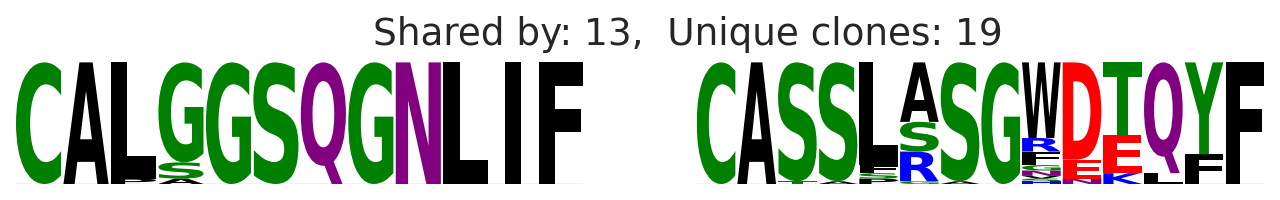

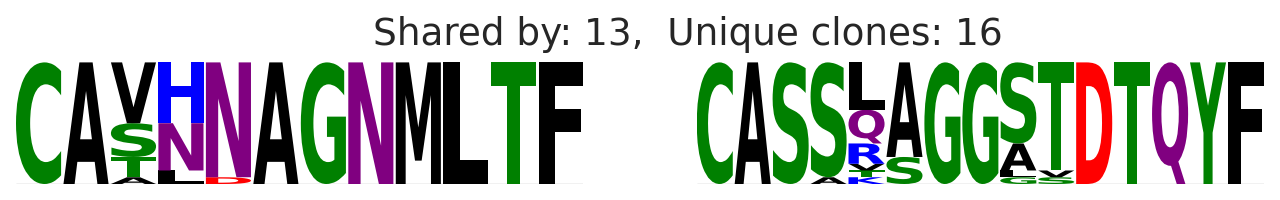

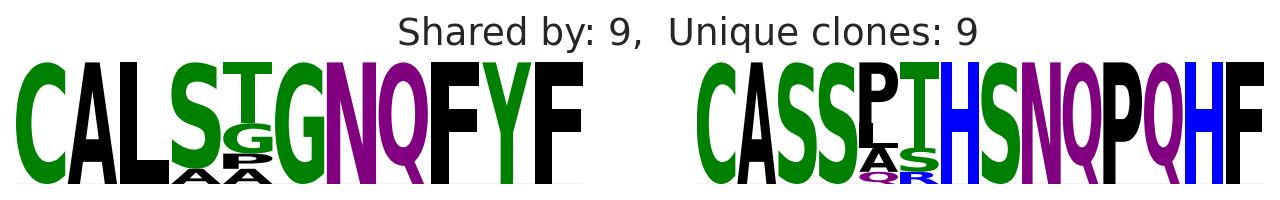

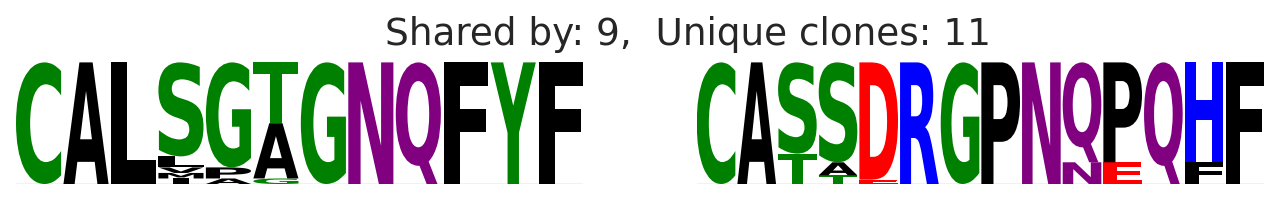

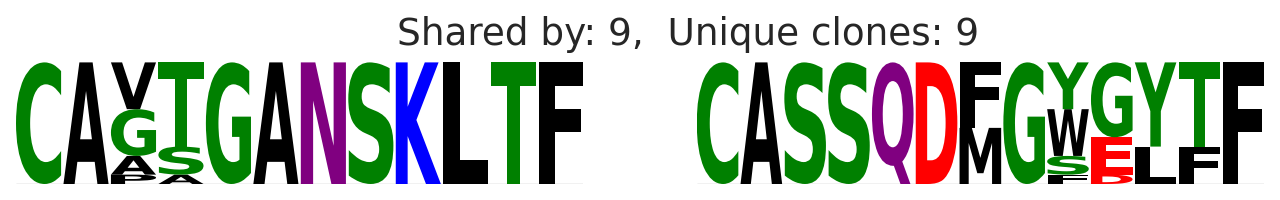

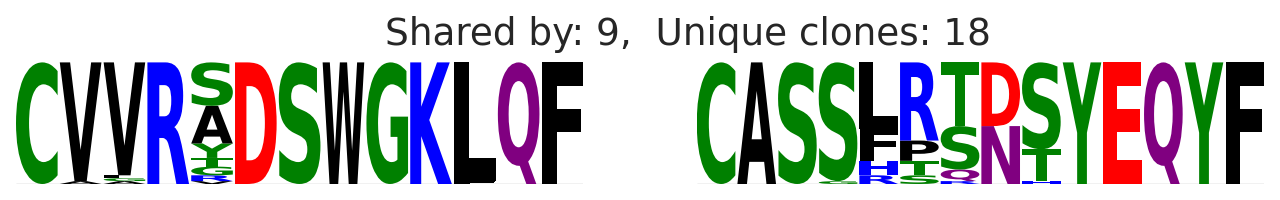

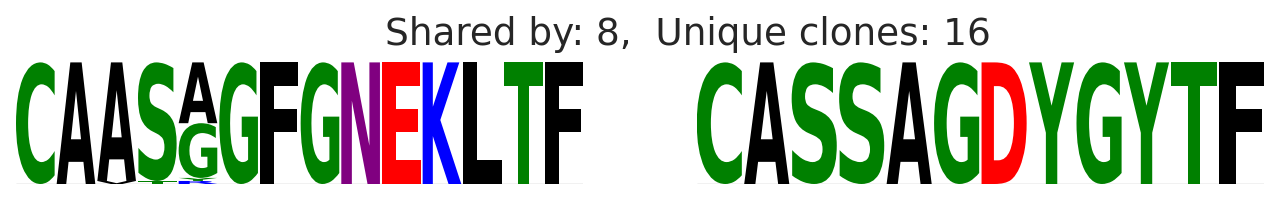

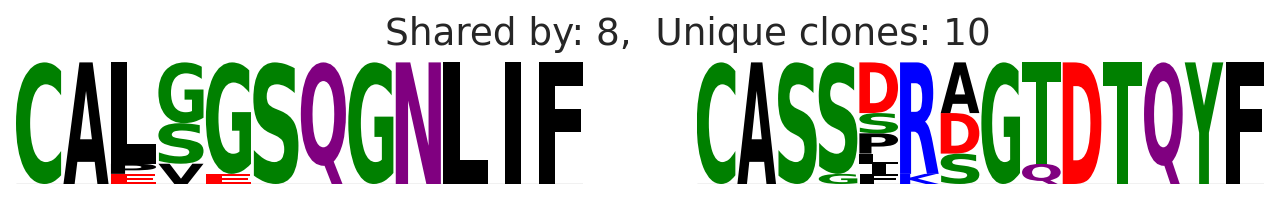

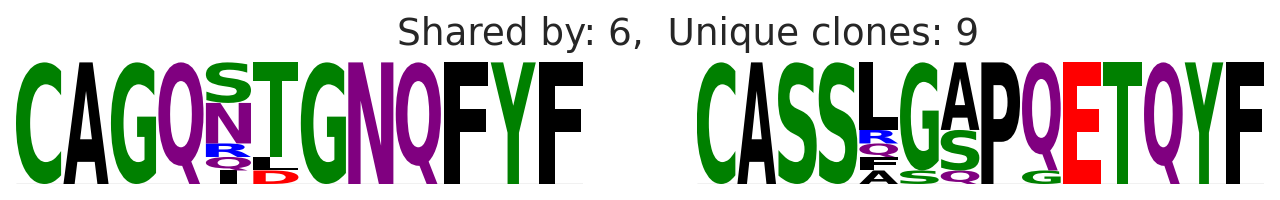

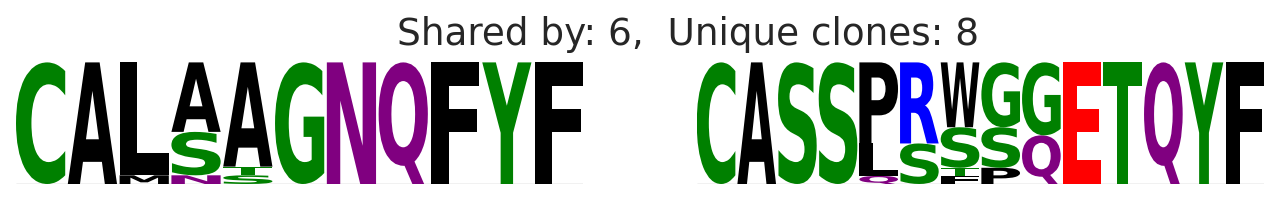

In [8]:
# show both chains side by side
for cluster, n_shared in (df_clone.groupby(['motif'])['subject'].nunique()).reset_index().sort_values('subject', ascending=False)[:10].values:
    cell2tcr.draw_cdr3(df_clone[df_clone.motif==cluster])

# Antigen discovery

In [9]:
iedb = pd.read_csv('/nfs/team205/ld21/public/antigen/IEDB_sars_cov_2.csv')
iedb = iedb.loc[:,iedb.isna().sum(axis=0)<10000]
iedb_beta = iedb[['Antigen','Chain 2 CDR3 Curated']]

vdjdb = pd.read_csv('/nfs/team205/ld21/public/antigen/VDJDB_sars_cov_2.tsv', sep='\t')
vdjdb.head(3)

/tmp/ipykernel_4816/53306116.py:1: DtypeWarning: Columns (13,16,20,24,46,47,50) have mixed types. Specify dtype option on import or set low_memory=False.
  iedb = pd.read_csv('/nfs/team205/ld21/public/antigen/IEDB_sars_cov_2.csv')


,complex.id,Gene,CDR3,V,J,Species,MHC A,MHC B,MHC class,Epitope,Epitope gene,Epitope species,Reference,Method,Meta,CDR3fix,Score
0,0,TRB,CASSQTTKDEQYF,TRBV4-2*01,TRBJ2-7*01,HomoSapiens,HLA-A*03:01,B2M,MHCI,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.199348284"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASSQTTKDEQYF"", ""cdr3_old"": ""CASSQTT...",1
1,0,TRB,CASSQGQKDEQYF,TRBV4-2*01,TRBJ2-7*01,HomoSapiens,HLA-A*03:01,B2M,MHCI,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.156986774"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASSQGQKDEQYF"", ""cdr3_old"": ""CASSQGQ...",1
2,0,TRB,CASSQFTGRKEKLFF,TRBV16*01,TRBJ1-4*01,HomoSapiens,HLA-A*03:01,B2M,MHCI,KTFPPTEPK,Nucleocapsid,SARS-CoV-2,https://github.com/antigenomics/vdjdb-db/issue...,"{""frequency"": ""0.081656124"", ""identification"":...","{""cell.subset"": ""CD8+ expansion"", ""clone.id"": ...","{""cdr3"": ""CASSQFTGRKEKLFF"", ""cdr3_old"": ""CASSQ...",1


In [11]:
df_clone['iedb'] = df_clone.cdr3_b_aa.isin(iedb_beta['Chain 2 CDR3 Curated'])

# mark whole Leiden cluster if any of its motifs match
iedb_leiden = np.zeros((df_clone.motif.nunique(),), dtype=bool)
for i in df_clone.motif.unique():
    iedb_leiden[i] = df_clone[df_clone.motif==i].iedb.sum()>0

df_clone['iedb_leiden'] = df_clone.motif.apply(lambda x: iedb_leiden[x])
p_adata.obs['clone_id'] = p_adata.obs.groupby(['subject','cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene'], sort=False).ngroup()
p_adata.obs['activated'] = p_adata.obs.celltypist_majority.isin(celltypist_activated)
p_adata.obs['in_iedb'] = p_adata.obs.cdr3_b_aa.isin(iedb['Chain 2 CDR3 Curated'])

def get_type(row):
    if row.celltypist_majority in celltypist_activated:
        return 'Activated'
    elif 'CM' in row.celltypist_majority or 'EM' in row.celltypist_majority: 
        return 'Memory'
    elif 'Naive' in row.celltypist_majority: 
        return 'Naive'
    else:
        return 'Effector'

p_adata.obs['Broad type'] = p_adata.obs.apply(get_type, axis=1)

# only consider unique clones
clones_types = p_adata.obs[['clone_id', 'celltypist_majority','Broad type', 'in_iedb']].drop_duplicates('clone_id')

# fold change
for i in ['Naive', 'Memory', 'Effector']:
    print('Activated/'+i, clones_types[clones_types['Broad type']=='Activated'].in_iedb.mean()/clones_types[clones_types['Broad type']==i].in_iedb.mean())

clones_types[clones_types['Broad type']=='Activated'].in_iedb.mean()/clones_types[clones_types['Broad type']!='Activated'].in_iedb.mean()

Activated/Naive 3.773872252556915
Activated/Memory 3.253417458527697
Activated/Effector 3.8586631311574826


3.7432789692083572

## SFig 6i 

/tmp/ipykernel_4816/1088513504.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Memory vs. Activated: Mann-Whitney-Wilcoxon test two-sided, P_val:0.000e+00 U_stat=1.291e+09


Text(24.91666666666667, 0.5, 'Fraction of unique clones matching IEDB')

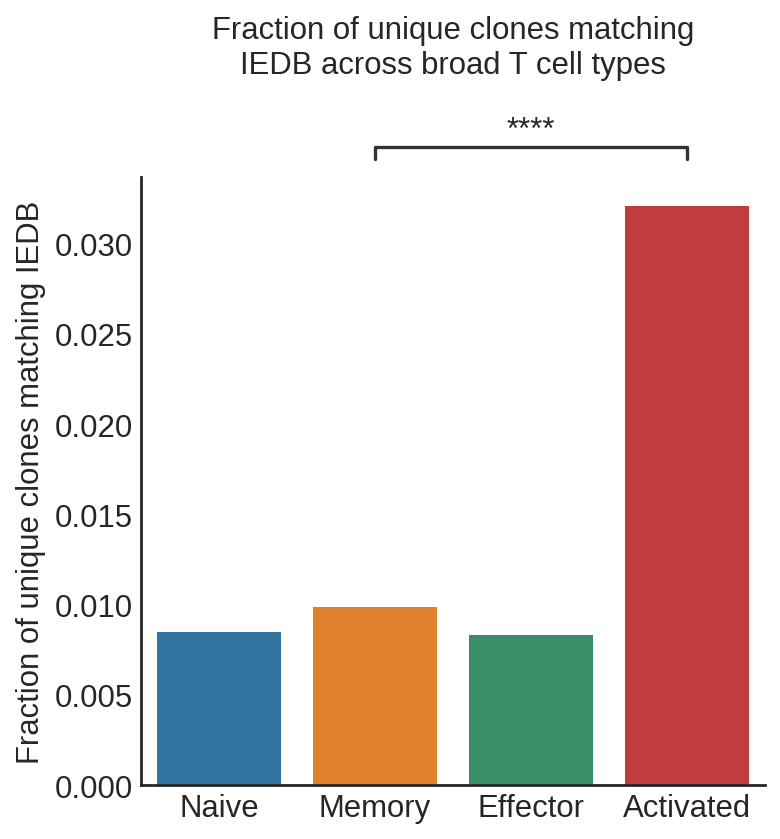

In [13]:
plt.style.use('seaborn-white')
plt.figure(figsize=(5,5))
ax = sns.barplot(
    data=clones_types, x='Broad type', y='in_iedb', ci=None, 
    order=['Naive', 'Memory', 'Effector', 'Activated'])
annotator = Annotator(ax, [('Memory', 'Activated')], order=['Naive', 'Memory', 'Effector', 'Activated'], data=p_adata.obs, x='Broad type', y='in_iedb')
annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
annotator.apply_and_annotate()
ax.set_xlabel(None)
plt.title('Fraction of unique clones matching\nIEDB across broad T cell types', y=1.15)
plt.ylabel('Fraction of unique clones matching IEDB')
# plt.savefig(savedir+'iedb_matches_broad_clones_frac_star')

In [14]:
# calculate test statistic
stats.mannwhitneyu(
    clones_types[clones_types['Broad type']=='Activated'].in_iedb.values,
    clones_types[clones_types['Broad type']!='Activated'].in_iedb.sample(n=clones_types['Broad type'].value_counts().Activated).values,
#     alternative='greater'
)

sample = 5000
random_state = 987654321

p_vals = list()
for i in range(10):
    p_vals.append(stats.mannwhitneyu(
        clones_types[clones_types['Broad type']=='Activated'].in_iedb.sample(n=sample, random_state=random_state).values,
        clones_types[clones_types['Broad type']!='Activated'].in_iedb.sample(n=sample, random_state=random_state).values,
    #     alternative='greater'
    )[1])
np.median(p_vals)

1.6847228258487238e-21

# Clustering of Activated Motifs

In [15]:
df_clone['cdr3_a_aa'] = df_clone.cdr3_a_aa.astype(str)
df_clone['cdr3_b_aa'] = df_clone.cdr3_b_aa.astype(str)
df_clone['total_junction'] = df_clone.cdr3_a_aa + df_clone.cdr3_b_aa

# indices of clusters with 2 or more unique subjects
# clone_clusters = np.arange(df_clone.motif.nunique())[(df_clone.groupby('motif').nunique().subject.ge(4)|df_clone.groupby('motif').nunique().cdr3_b_aa.ge(4)).values]
clone_clusters = np.arange(df_clone.motif.nunique())[df_clone.groupby('motif').nunique().total_junction.ge(5).values]
# clone_clusters = np.arange(df_clone.motif.nunique())[(df_clone.groupby('motif').nunique().cdr3_a_aa.ge(4))|(df_clone.groupby('motif').nunique().cdr3_b_aa.ge(4)).values]
clone_subset = df_clone[df_clone.motif.isin(clone_clusters)].copy()
print(clone_subset.drop_duplicates(subset = 'clone_id').shape)

(192, 155)


In [16]:
tr_sub = cell2tcr.motifs(clone_subset, sparse=False, add_suffix=False, return_distances=True)

In [17]:
def get_antigen(row):
    x = row.iedb_antigen
    if len(x) > 1:
        if x[0] == '':
            return x[1]
        else:
            return x[0]
    else:
        return x[0]    
def get_antigen_dict_key(key):
    if key == '':
        return 'unknown'
    elif bool(re.search('1ab', key, flags=re.I)) or bool(re.search('structur', key, flags=re.I)) or bool(re.search('replicase', key, flags=re.I)):
        return 'ORF1ab'
    elif bool(re.search('spike', key, flags=re.I)) or bool(re.search('surface', key, flags=re.I)):
        return 'S'
    elif bool(re.search('membrane', key, flags=re.I)):
        return 'M'
    elif bool(re.search('envelope', key, flags=re.I)):
        return 'E'
    elif bool(re.search('nucle', key, flags=re.I)):
        return 'N'
    elif bool(re.search('orf3a', key, flags=re.I)):
        return 'ORF3a'
    elif bool(re.search('orf7b', key, flags=re.I)):
        return 'ORF7b'
    elif bool(re.search('orf7a', key, flags=re.I)):
        return 'ORF7a'
    else:
        return 'NO MATCH'    
    
tr_sub.clone_df['iedb'] = tr_sub.clone_df.cdr3_b_aa.isin(iedb_beta['Chain 2 CDR3 Curated'])

# mark whole Leiden cluster if any of its motifs match
iedb_leiden = np.zeros((tr_sub.clone_df.motif.max()+1,), dtype=bool)
for i in tr_sub.clone_df.motif.unique():
    iedb_leiden[i] = tr_sub.clone_df[tr_sub.clone_df.motif==i].iedb.sum()>0
tr_sub.clone_df['iedb_leiden'] = tr_sub.clone_df.motif.apply(lambda x: iedb_leiden[x])

# assign antigen if in iedb.org
tr_sub.clone_df['iedb_antigen'] = tr_sub.clone_df.apply(lambda row: iedb_beta[iedb_beta['Chain 2 CDR3 Curated']==row.cdr3_b_aa].Antigen.values[0].split('[')[0] if row.iedb else '', axis=1)
cluster_antigens = tr_sub.clone_df.groupby('motif').agg(np.unique).iedb_antigen.reset_index()
cluster_antigens['antigen_clean'] = cluster_antigens.apply(get_antigen, axis=1)

# clean up antigen formatting
cluster_antigens['antigen_short'] = cluster_antigens.antigen_clean.apply(get_antigen_dict_key)
cluster_antigen_dict = cluster_antigens[['motif', 'antigen_short']].set_index('motif').to_dict()['antigen_short']
# assign antigen to Leiden clusters
tr_sub.clone_df['leiden_antigen'] = tr_sub.clone_df.motif.map(cluster_antigen_dict)

# we don't care about variation if sequences are already too far apart
# tr_sub.pw_alpha[tr_sub.pw_alpha>40] = 35
# tr_sub.pw_beta[tr_sub.pw_beta>40] = 35
tr_sub.clone_df['subject'] = tr_sub.clone_df.subject.astype(str)
tr_sub.clone_df['study'] = tr_sub.clone_df.study.astype(str)
tr_sub.clone_df['motif'] = tr_sub.clone_df.motif.astype(str)
tr_sub.clone_df['leiden_antigen'] = tr_sub.clone_df.leiden_antigen.astype(str)

lut2 = dict(zip(tr_sub.clone_df.subject.unique(), sns.palettes.color_palette(n_colors=len(tr_sub.clone_df.subject.unique()),palette='deep')))
lut5 = dict(zip(tr_sub.clone_df.motif.unique(), sns.palettes.color_palette(n_colors=len(tr_sub.clone_df.motif.unique()),palette='tab20')))
lut1 = dict(zip(tr_sub.clone_df.leiden_antigen.unique(), sns.palettes.color_palette(n_colors=len(tr_sub.clone_df.leiden_antigen.unique()),palette='deep')))
lut1['unknown'] = 'lightgrey'
lut3 = dict(zip(tr_sub.clone_df.study.unique(), sns.palettes.color_palette(n_colors=len(tr_sub.clone_df.study.unique()),palette='deep')))

/tmp/ipykernel_4816/993110835.py:42: FutureWarning: ['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_ADT', 'nFeature_ADT', 'soupxOnAdt', 'soupxOnRna', 'percentMito', 'yoshida_broad_predLabel', 'yoshida_broad_maxPredProb', 'haniffa_broad_predLabel', 'haniffa_broad_maxPredProb', 'celltypist_broad_predLabel', 'celltypist_broad_maxPredProb', 'yoshida_detailed_predLabel', 'yoshida_detailed_maxPredProb', 'haniffa_detailed_predLabel', 'haniffa_detailed_maxPredProb', 'celltypist_detailed_predLabel', 'celltypist_detailed_maxPredProb', 'viral_abundance_soupx', 'viral_abundance_raw', 'harmony_snn_res.0.5', 'harmony_snn_res.4', 'seurat_clusters', 'samples_in_pool', 'target_cell_number_per_pool', 'PCR_cycles', 'cDNA_storage_temp', 'Viability', 'AB_vial_added', 'souporcell_status', 'souporcell_cluster', 'souporcell_cluster_matched', 'ucl_id', 'time_point', 'covid_status', 'hlaCompatibleWDextramers', 'age', 'ethnicity', 'race', 'race_details', 'allergies', 'time_of_challenge', 'annotation_1', 'an

## Fig 4d - clustermap

/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


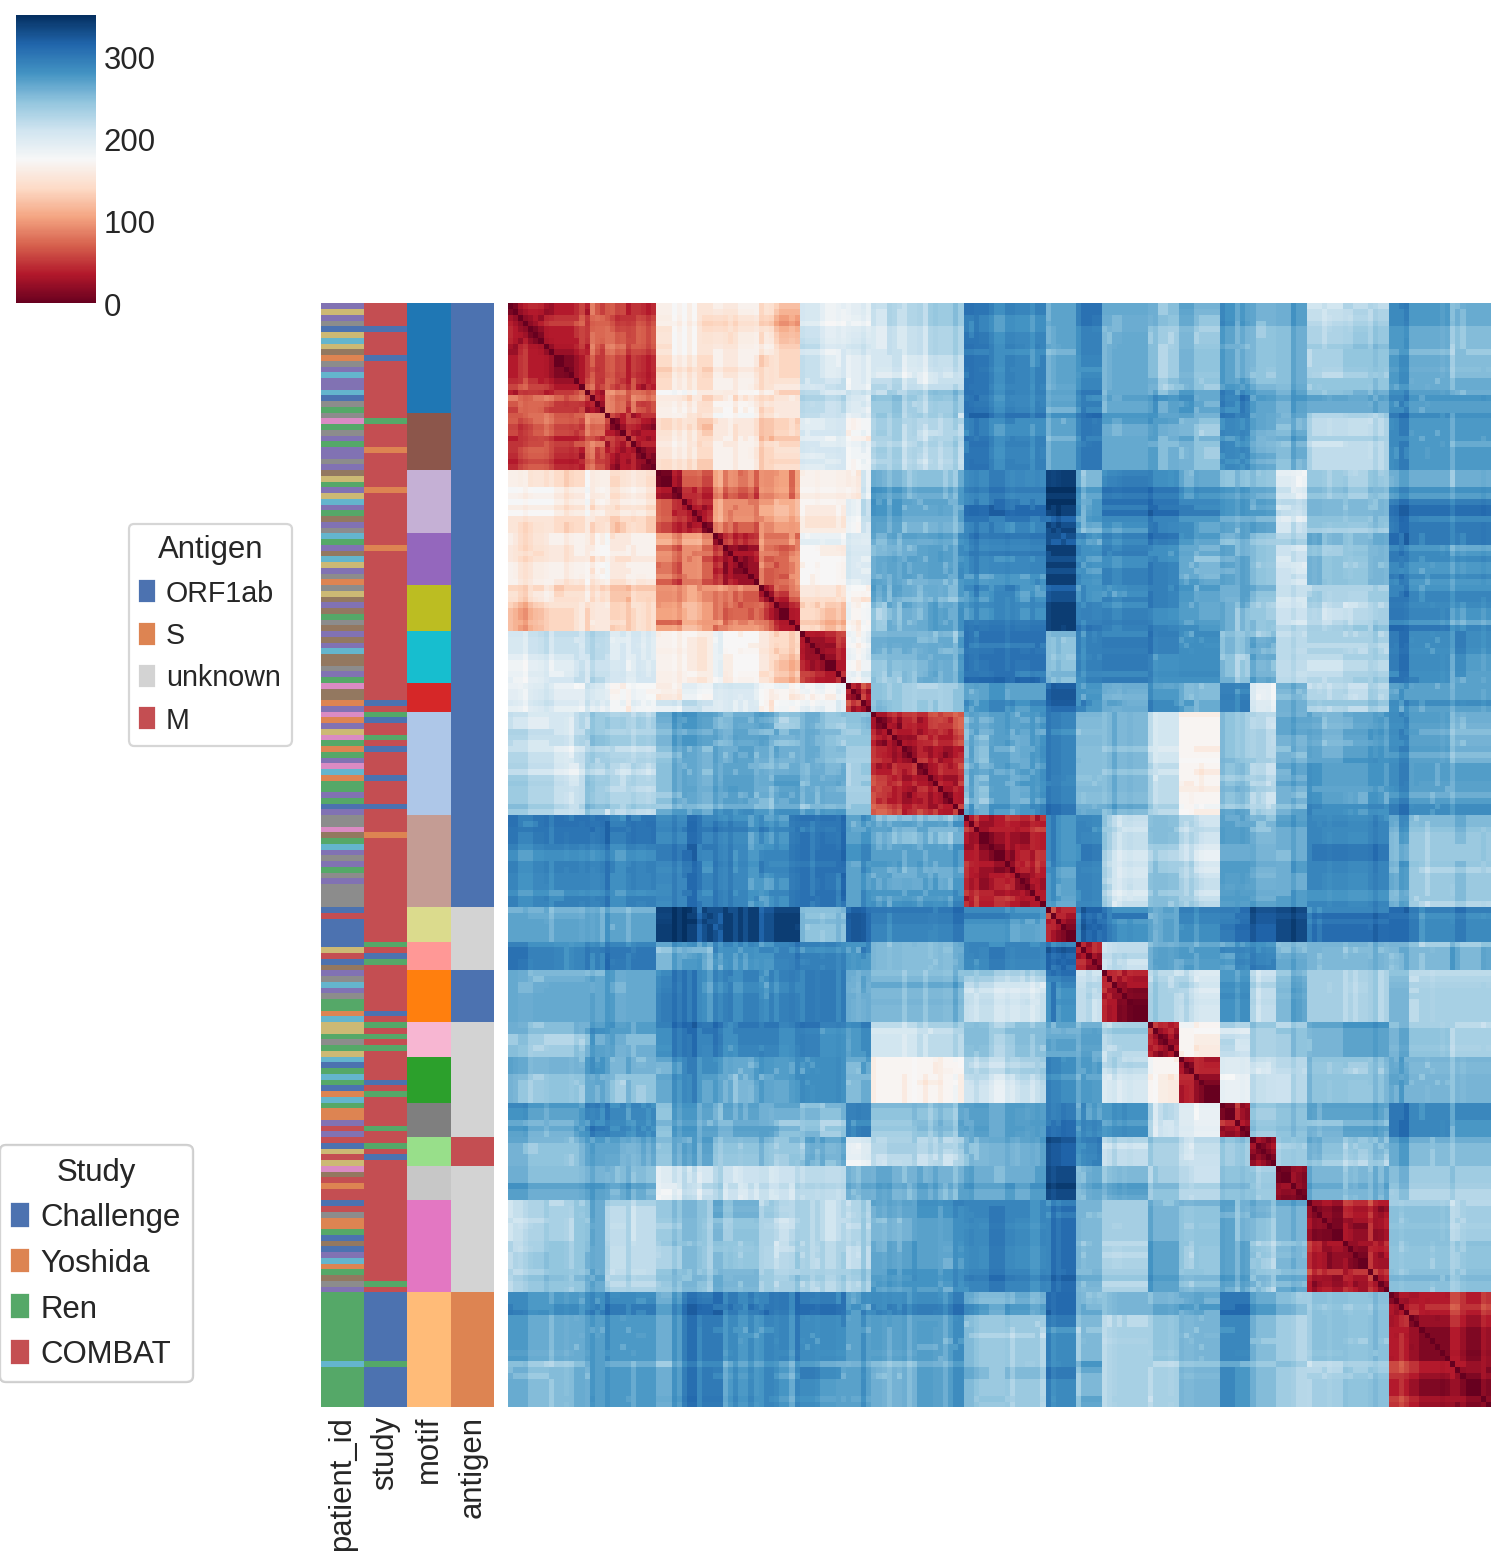

In [18]:
# row colors
colors = pd.DataFrame(index=tr_sub.clone_df.index)
colors['patient_id'] = tr_sub.clone_df.subject.map(lut2)
colors['study'] = tr_sub.clone_df.study.map(lut3)
colors['motif'] = tr_sub.clone_df.motif.map(lut5)
colors['antigen'] = tr_sub.clone_df.leiden_antigen.map(lut1)
colors.reset_index(drop=True, inplace=True)

g = sns.clustermap(pd.DataFrame(tr_sub.pw_alpha+tr_sub.pw_beta), method='ward', cmap='RdBu', row_colors=colors)
g.ax_heatmap.set(xticklabels=[])
g.ax_heatmap.set(yticklabels=[])
g.ax_row_dendrogram.set_visible(False) #suppress row dendrogrm
g.ax_col_dendrogram.set_visible(False) #suppress column dendrogram

# legend for antigen
colors['antigen_name'] = tr_sub.clone_df.leiden_antigen.values
legend_antigen = [mpatches.Patch(color=c, label=l) for c,l in colors[['antigen','antigen_name']].drop_duplicates().values]
l_antigen = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(-0.4,0.7),handles=legend_antigen,frameon=True)
l_antigen.set_title(title='Antigen',prop={'size':14})

# legend for study
colors['study_name'] = tr_sub.clone_df.study.values
legend_study = [mpatches.Patch(color=c, label=l) for c,l in colors[['study','study_name']].drop_duplicates().values]
l_study = plt.legend(loc='center left',bbox_to_anchor=(0,0.2),handles=legend_study, title='Study',prop={'size':14},frameon=True, bbox_transform=plt.gcf().transFigure)
plt.gca().add_artist(l_study)
# plt.savefig(savedir+'public_clustermap_antigen_reduced.pdf')

## Fig 4d - motifs

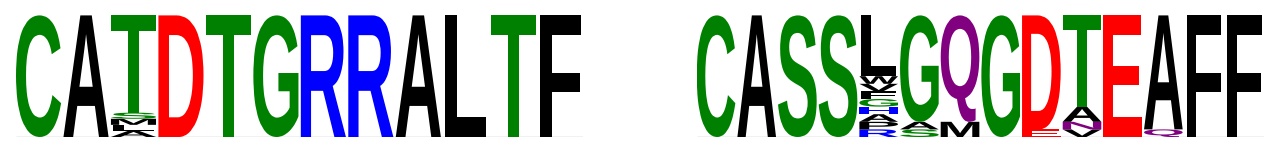

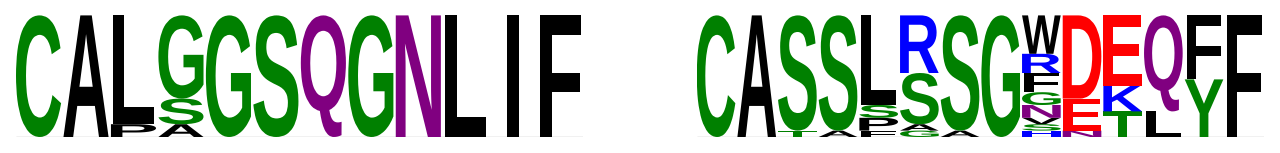

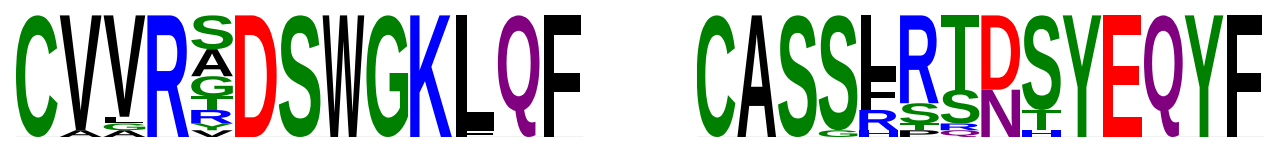

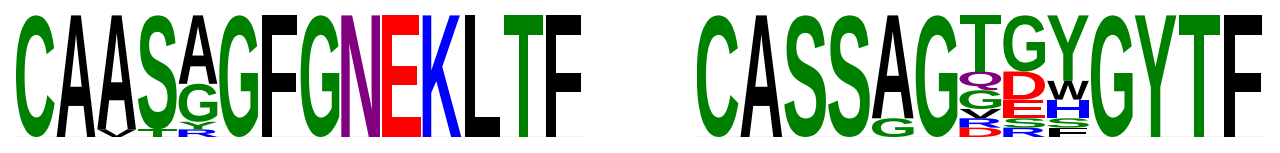

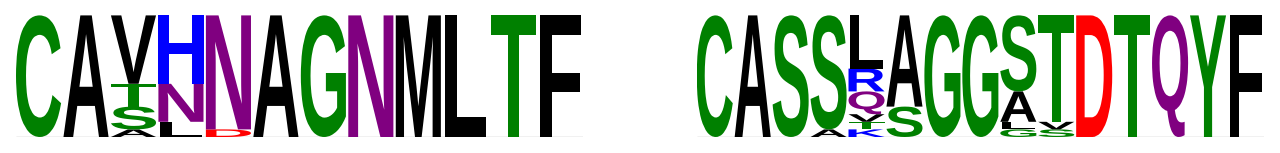

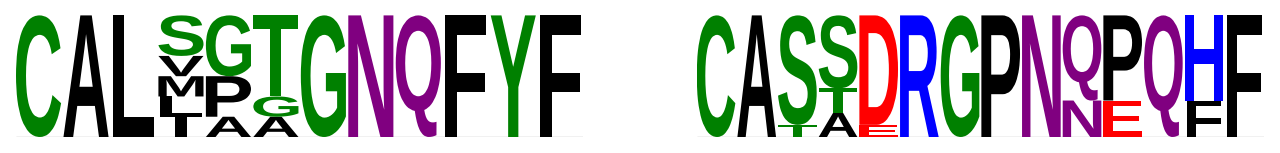

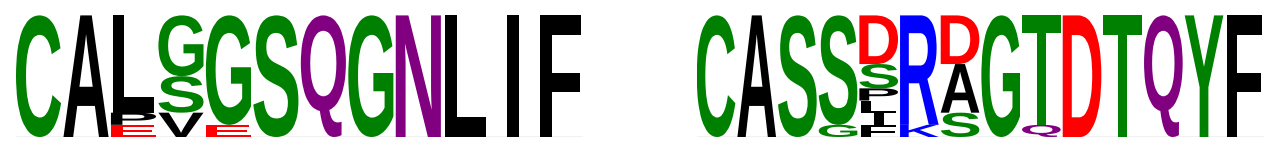

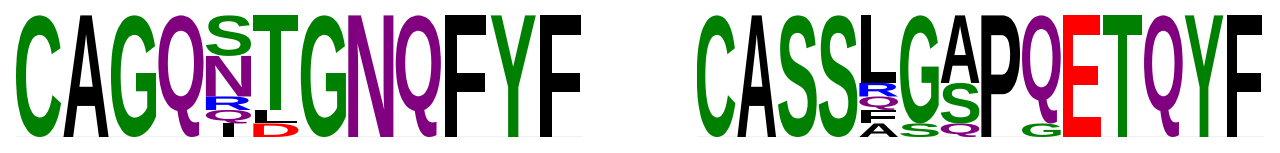

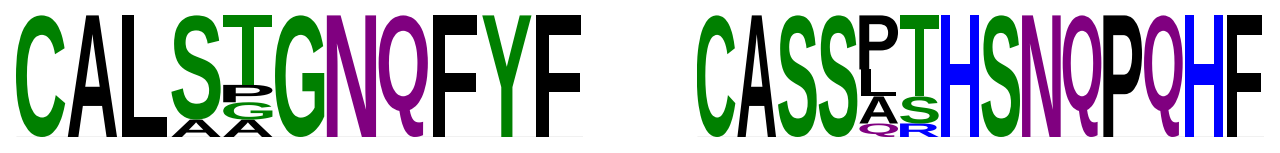

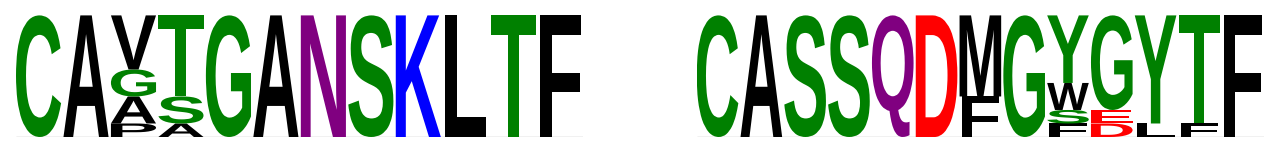

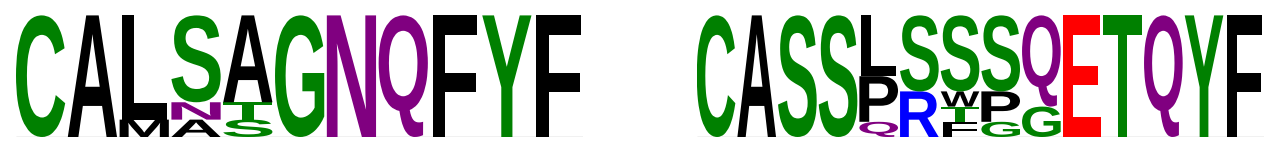

In [19]:
tr_sub.clone_df['motif'] = tr_sub.clone_df.motif.astype(int)
for i in range(11):
    cell2tcr.draw_cdr3(tr_sub.clone_df[tr_sub.clone_df.motif==i], put_title=False, transparent=True)#, savefig_title=savedir+f'activated_motif_transparent_{i}')

# Bulk VDJ analysis

In [20]:
c_adata.obs['new_covid_status'] = annotation.covid_status.loc[c_adata.obs_names]
infection_pd = c_adata.obs[['subject', 'new_covid_status']].drop_duplicates().set_index('subject')
infection_dict = c_adata.obs[['subject', 'new_covid_status']].drop_duplicates().set_index('subject').to_dict()['new_covid_status']

In [25]:
path = '/nfs/team205/ld21/challenge/data/bulk_data/raw_data_files/'

files = os.listdir(path)
files = [x.replace('pre','day-1') for x in files]
files = pd.DataFrame(files)

file_metadata = files[0].str.split('_', expand=True)
file_metadata['filename'] = os.listdir(path)
file_metadata[5] = file_metadata[5].str.replace('.csv','')
file_metadata[3] = file_metadata[3].str.replace('day','')
file_metadata.loc[file_metadata[3]=='post',3] = 1
file_metadata.drop(columns=[0,1,4], inplace=True)

/tmp/ipykernel_4816/3362246132.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  file_metadata[5] = file_metadata[5].str.replace('.csv','')


In [23]:
# get df_clone with all celltypes
df_clone_all_types = c_adata.obs[['annot_0111','subject','covid_status','cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene']].copy()
df_clone_all_types['celltypist_majority'] = df_clone_all_types.annot_0111.copy()
df_clone_all_types['celltypist'] = df_clone_all_types.annot_0111.copy() # same for Challenge data
df_clone_all_types['study'] = 'Challenge'
df_clone_all_types['clone_id'] = df_clone_all_types.groupby(['subject','cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene'], sort=False).ngroup()

# set of Activated CDR3s: check their appearance in bulk over the days
activated_cdr3_a = set(df_clone_all_types[(df_clone_all_types.subject.isin(infection_pd[infection_pd.new_covid_status=='Sustained infection'].index.values))&(df_clone_all_types.annot_0111.isin(celltypist_activated))].cdr3_a_aa)
activated_cdr3_b = set(df_clone_all_types[(df_clone_all_types.subject.isin(infection_pd[infection_pd.new_covid_status=='Sustained infection'].index.values))&(df_clone_all_types.annot_0111.isin(celltypist_activated))].cdr3_b_aa)

In [32]:
# load bulk data
df = pd.read_csv('/nfs/team205/ld21/challenge/data/bulk_data/bulk_processed_subjects_in_sc.csv', index_col=0)

# df = df[df.day.isin(['-1','7','14'])]
df['day_num'] = df.day.copy()
df['day'] = df.day.astype(str)
df['subject'] = df.subject.astype(str)
df['activated_cdr3'] = df.junction_aa.isin(activated_cdr3_a) | df.junction_aa.isin(activated_cdr3_b)
df['clone_id'] = df.groupby(['subject','junction_aa', 'v_call', 'j_call', 'chain'], sort=False).ngroup()

# custom sorter for column values, for use in sort_values
sorter = pd.DataFrame(celltypist_activated+list(df_clone_all_types.annot_0111.unique())).drop_duplicates().iloc[:,0].tolist()
def sorter_func(column): return column.map({ctype: order for order, ctype in enumerate(sorter)})

# assign celltypes to bulk TCRs by finding matches in sc data
df['celltype'] = ''
dict_cdr3_b = collections.defaultdict(str, df_clone_all_types[['annot_0111','cdr3_b_aa']].sort_values(by='annot_0111', key=sorter_func).drop_duplicates('cdr3_b_aa').set_index('cdr3_b_aa').annot_0111.to_dict())
dict_cdr3_a = collections.defaultdict(str, df_clone_all_types[['annot_0111','cdr3_a_aa']].sort_values(by='annot_0111', key=sorter_func).drop_duplicates('cdr3_a_aa').set_index('cdr3_a_aa').annot_0111.to_dict())
df.loc[df.chain=='beta','celltype'] = df.loc[df.chain=='beta','junction_aa'].map(dict_cdr3_b)
df.loc[df.chain=='alpha','celltype'] = df.loc[df.chain=='alpha','junction_aa'].map(dict_cdr3_a)
df['activated_celltype'] = df.celltype.isin(celltypist_activated)
dict_sample = {j:i for i,j in enumerate(file_metadata[2].str.cat(file_metadata[[3,5]].astype(str)).values)}
df['sample_id'] = df.apply(lambda x: dict_sample[x.subject+x.day+x.chain], axis=1)

# compute total duplicate count
df['total_duplicate_count'] = df.sample_id.map(df.groupby('sample_id').sum().duplicate_count.to_dict())
df['duplicate_count_frac'] = df.duplicate_count/df.total_duplicate_count
# df['broad_type'] = ''
# df.loc[df.celltype.str.contains('CM|EM'), 'broad_type'] = 'Memory'
# df.loc[df.celltype.str.contains('Naive'), 'broad_type'] = 'Naive'
df['status'] = df.subject.map(infection_dict)
df.drop(columns=['decombinator_id','sequence_aa','cdr1_aa','cdr2_aa'], inplace=True)

/tmp/ipykernel_4816/868191505.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df['total_duplicate_count'] = df.sample_id.map(df.groupby('sample_id').sum().duplicate_count.to_dict())


In [33]:
# df['annotated'] = df.celltype != ''
df_w_celltype = df.groupby('sample_id').mean()
df_w_celltype['chain'] = df_w_celltype.index.map(df[['sample_id','chain']].drop_duplicates().set_index('sample_id').chain.to_dict())
df_w_celltype = df[df.celltype!='']
df_w_celltype['new_total_duplicate_count'] = df_w_celltype.sample_id.map(df_w_celltype.groupby('sample_id').sum().duplicate_count.to_dict())
df_w_celltype['new_duplicate_count_frac'] = df_w_celltype.duplicate_count/df_w_celltype.new_total_duplicate_count

t = df_w_celltype.groupby(['subject','celltype','day_num','chain']).sum().reset_index()
t['day_num'] = t.day_num.astype(int)
# t['duplicate_count_frac_rel_day-1'] = t.apply(lambda x: x.new_duplicate_count_frac/t.loc[(t.celltype==x.celltype)&(t.subject==x.subject)&(t.day_num==-1)&(t.chain==x.chain)].new_duplicate_count_frac.values, axis=1)
# t = t.explode('duplicate_count_frac_rel_day-1')
# t['log2_duplicate_count_frac_rel_day-1'] = np.log2(t['duplicate_count_frac_rel_day-1'].astype(float))
t['status'] = t.subject.map(infection_dict)
t['day'] = t.day_num

ctypes = [
    'T CD4 Activated CTL Cycling',
    'T CD4 Activated Helper 1 Cycling',
    'T CD8 Activated CTL',
    'T Reg Activated Cycling',
    'T CD4 Activated CTL',
    'T CD4 Activated Helper 1',
    'T CD8 Activated CTL Cycling',
    'T Reg Activated',
    'T CD4 Helper 1',
    'T Reg CM',
    'T CD4 Follicular Helper',
    'T CD4 Helper 0']
ctypes = sorted(ctypes)

/tmp/ipykernel_4816/579525109.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_w_celltype = df.groupby('sample_id').mean()
/tmp/ipykernel_4816/579525109.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_w_celltype['new_total_duplicate_count'] = df_w_celltype.sample_id.map(df_w_celltype.groupby('sample_id').sum().duplicate_count.to_dict())
/tmp/ipykernel_4816/579525109.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

## Fig 3g, SFig 6f

/tmp/ipykernel_4816/8703948.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


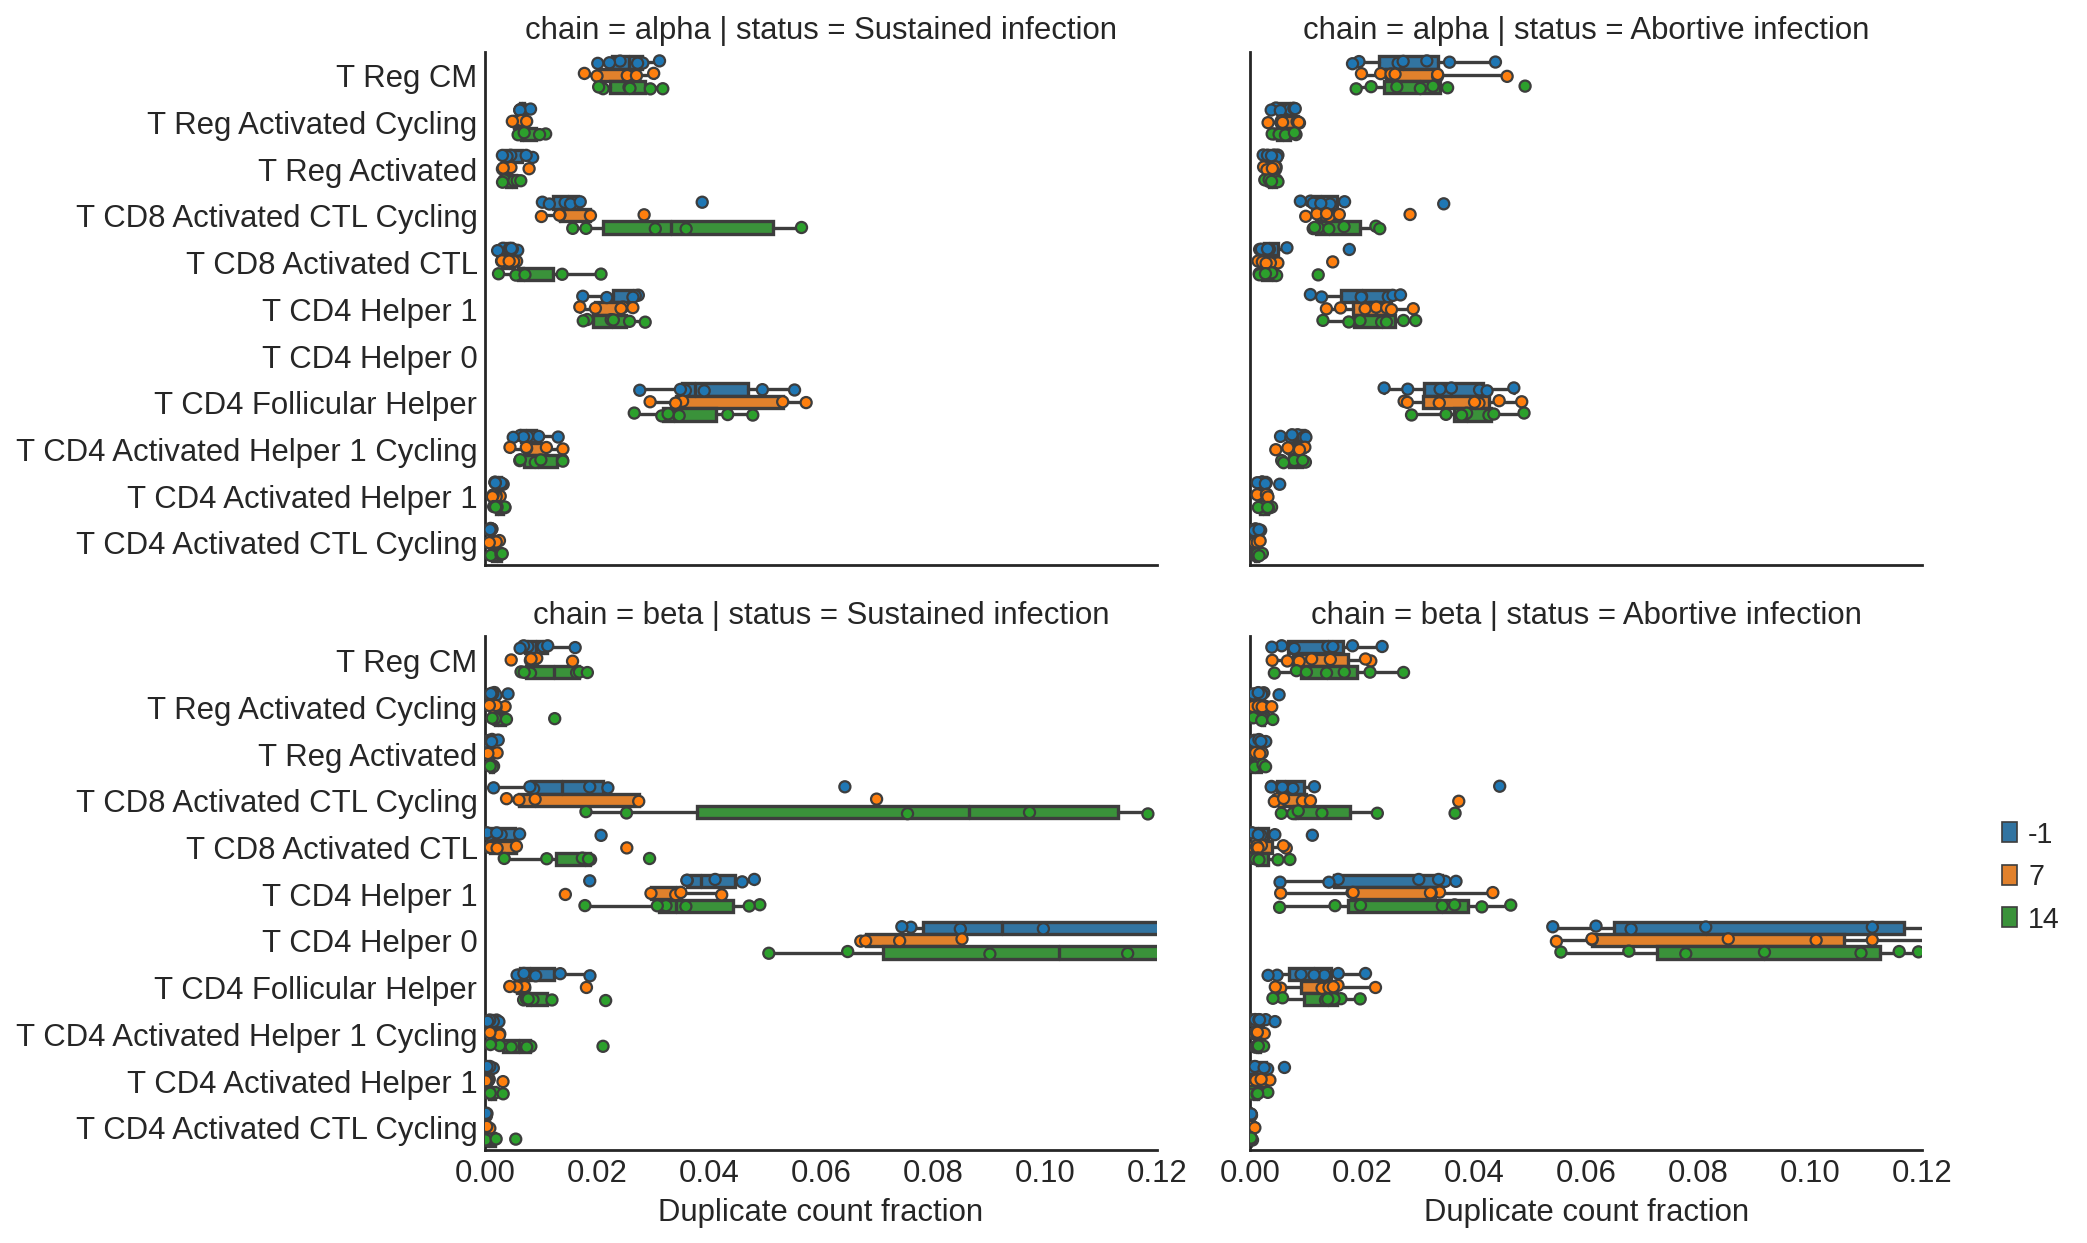

In [35]:
plt.style.use('seaborn-white')
g = sns.FacetGrid(t, col='status', row='chain', aspect=1.5, height=4, xlim=(0,0.12), col_order=['Sustained infection','Abortive infection'])
g.map_dataframe(
    sns.boxplot, y='celltype', x='new_duplicate_count_frac', order = list(reversed(ctypes))[:-1], 
    hue='day', hue_order=[-1,7,14], fliersize=0, palette='tab10')
g.add_legend(bbox_to_anchor=(1.05,0.3))
g.map_dataframe(
    sns.stripplot, y='celltype', x='new_duplicate_count_frac', order = list(reversed(ctypes))[:-1], 
    hue='day', hue_order=[-1,7,14], dodge=True, palette='tab10', linewidth=1)
g.set_ylabels('')
g.set_xlabels('Duplicate count fraction')
plt.tight_layout()
# plt.savefig(savedir+'bulk_celltype_dynamics.pdf')

# Memory formation
## SFig 6e

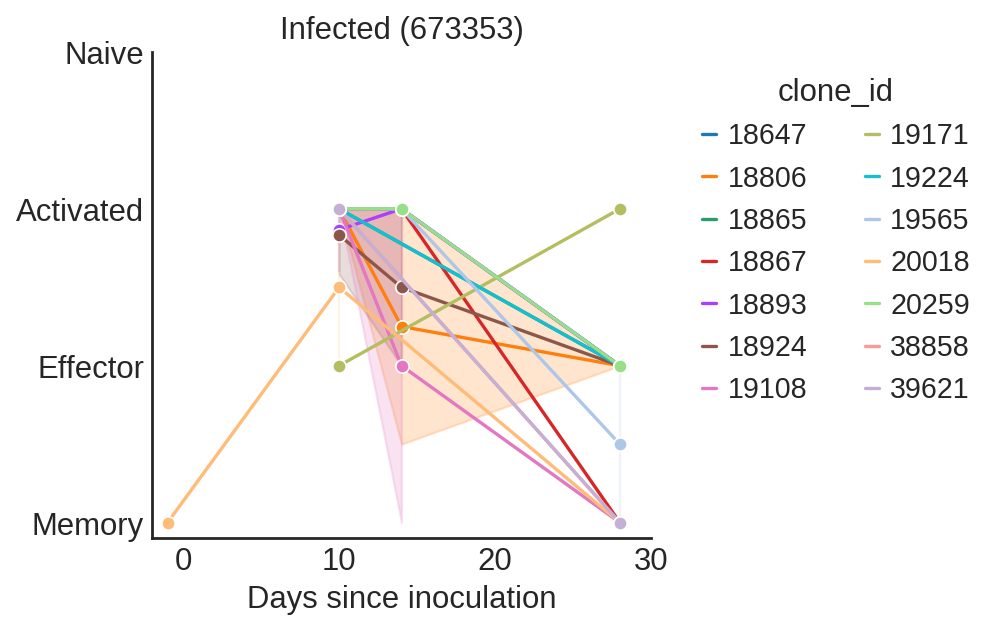

In [36]:
subject = '673353' # individual with many clones captured
stages = ['Memory', 'Effector', 'Activated', 'Naive']
stage_dict = {i:j for j, i in enumerate(stages)}
def get_stage(label):
    if 'Activated' in label:
        return stage_dict['Activated']
    elif 'CM' in label or 'EM' in label:
        return stage_dict['Memory']
    elif 'Naive' in label:
        return stage_dict['Naive']
    else:
        return stage_dict['Effector']
c_adata.obs['time_point_num'] = c_adata.obs.time_point.str[1:].astype(int)
c_adata.obs['stage'] = c_adata.obs.annot_0111.apply(get_stage)
c_adata.obs['time_point']
c_adata.obs['clone_id'] = c_adata.obs.groupby(['subject','cdr3_b_aa', 'v_b_gene', 'j_b_gene', 'cdr3_a_aa', 'v_a_gene', 'j_a_gene'], sort=False).ngroup()
c_adata.obs['clone_id_str'] = c_adata.obs.clone_id.astype(str)
c_sub = c_adata[c_adata.obs.subject==subject].copy()
# get clone IDs of Activated T cells per subject 
act_clones = c_sub[(c_sub.obs.subject==subject)&(c_sub.obs.annot_0111.isin(celltypist_activated))].obs.clone_id.unique()

act_clones_keep = list()
for i in act_clones:
#         if c_sub[c_sub.obs.clone_id==i].obs.annot_0111.nunique()>1: # if more than 1 annotation 
    if c_sub[c_sub.obs.clone_id==i].obs.time_point_num.nunique()>1: # if more than 1 day
        if 28 in c_sub[c_sub.obs.clone_id==i].obs.time_point_num.unique(): # if present at D28
            act_clones_keep.append(i)

c_sub = c_sub[c_sub.obs.clone_id.isin(act_clones_keep)]

plt.figure()
sns.lineplot(
    data=c_sub.obs, x='time_point_num', y='stage', marker='o', hue='clone_id_str', )#ci=None, estimator=None)
plt.yticks(range(len(stages)), stages)
plt.title(f'Infected ({subject})')
plt.legend(bbox_to_anchor=(1.05, 1), ncol=int(np.ceil(len(act_clones_keep)/10)), title='clone_id')
plt.xlim((-2,30))
plt.ylabel(None)
plt.xlabel('Days since inoculation');
# plt.savefig(savedir+subject+'.pdf')

# Dextramer analysis

In [37]:
tcr_adata = sc.read_h5ad('/nfs/team205/ld21/challenge/data/dextramer_with_time_points.h5ad')
tcr_adata

AnnData object with n_obs × n_vars = 13976 × 20868
    obs: 'is_cell', 'high_confidence', 'multi_chain', 'extra_chains', 'IR_VJ_1_c_call', 'IR_VJ_2_c_call', 'IR_VDJ_1_c_call', 'IR_VDJ_2_c_call', 'IR_VJ_1_consensus_count', 'IR_VJ_2_consensus_count', 'IR_VDJ_1_consensus_count', 'IR_VDJ_2_consensus_count', 'IR_VJ_1_d_call', 'IR_VJ_2_d_call', 'IR_VDJ_1_d_call', 'IR_VDJ_2_d_call', 'IR_VJ_1_duplicate_count', 'IR_VJ_2_duplicate_count', 'IR_VDJ_1_duplicate_count', 'IR_VDJ_2_duplicate_count', 'IR_VJ_1_j_call', 'IR_VJ_2_j_call', 'IR_VDJ_1_j_call', 'IR_VDJ_2_j_call', 'IR_VJ_1_junction', 'IR_VJ_2_junction', 'IR_VDJ_1_junction', 'IR_VDJ_2_junction', 'IR_VJ_1_junction_aa', 'IR_VJ_2_junction_aa', 'IR_VDJ_1_junction_aa', 'IR_VDJ_2_junction_aa', 'IR_VJ_1_locus', 'IR_VJ_2_locus', 'IR_VDJ_1_locus', 'IR_VDJ_2_locus', 'IR_VJ_1_productive', 'IR_VJ_2_productive', 'IR_VDJ_1_productive', 'IR_VDJ_2_productive', 'IR_VJ_1_v_call', 'IR_VJ_2_v_call', 'IR_VDJ_1_v_call', 'IR_VDJ_2_v_call', 'has_ir', 'sanger_id', 'sam

In [40]:
# Dextramer bound/unbound counts
rik_dex = pd.read_csv('/nfs/team205/rl21/projects/RL007_challengeStudy/dextramer_with_time_points.obs.tsv', sep='\t')
tcr_adata.obs.loc[rik_dex.index, ['highest_bound_dextramer_matched','highest_bound_dextramer']] = rik_dex[['highest_bound_dextramer_matched','highest_bound_dextramer']].values
tcr_adata.obs['highest_bound_dextramer_matched'] = tcr_adata.obs['highest_bound_dextramer_matched'].astype(str)

# show number of bound/unbound cells by cell type
bound_state_init = pd.crosstab(tcr_adata.obs.celltypist_majority, tcr_adata.obs.highest_bound_dextramer_matched)
bound_state = bound_state_init.div(bound_state_init.iloc[:,0], axis=0)
bound_state = np.log2(bound_state)
bound_state[abs(bound_state)==np.inf] = np.nan
bound_state_init = bound_state_init.loc[bound_state.index.str.contains('CD8')]
bound_state = bound_state.loc[bound_state.index.str.contains('CD8')]

/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log2
  result = func(self.values, **kwargs)


## SFig 7d

/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


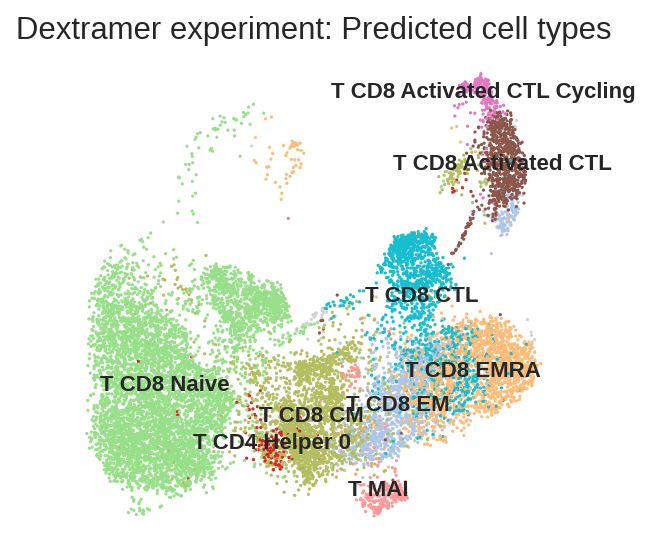

In [44]:
sc.pl.umap(
    tcr_adata, color='celltypist_majority', 
    groups=tcr_adata.obs.celltypist_majority.value_counts().keys()[:-4].values, 
    frameon=False, show=False, title='Dextramer experiment: Predicted cell types',
    na_in_legend=False, legend_loc='on data', legend_fontsize=10);
# plt.savefig(savedir+'umap_dextramer_cell_types.pdf')

## SFig 7e

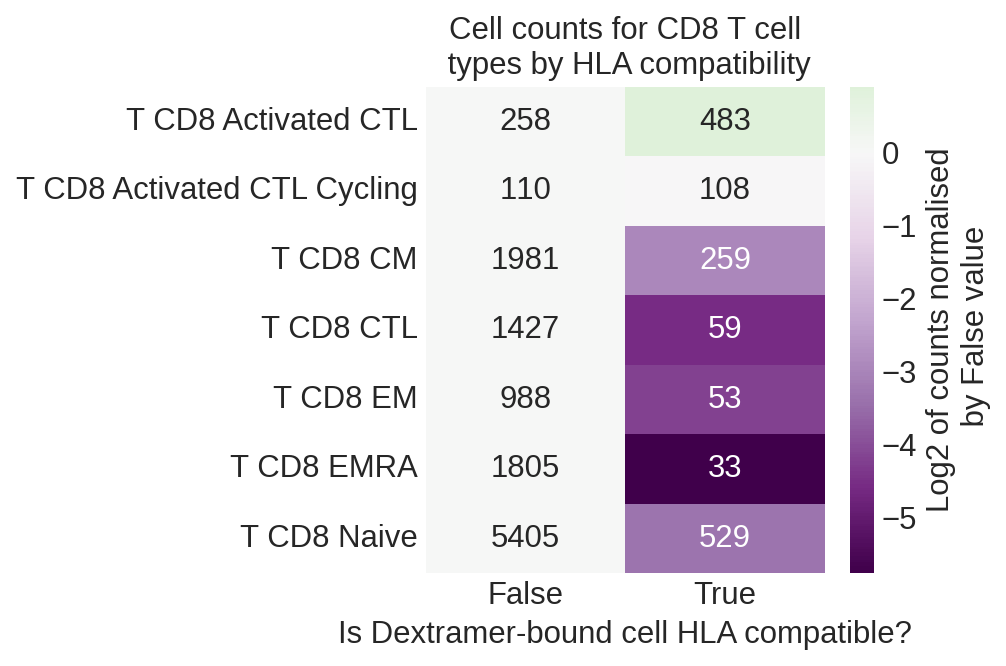

In [42]:
ax = sns.heatmap(
    bound_state, cmap='PRGn', annot=bound_state_init, fmt='.4g',
    vmin=bound_state.min()[1], vmax=bound_state.max()[1], center=0,
    cbar_kws={'label':'Log2 of counts normalised\n by False value'}
)
ax.set_ylabel('')
ax.set_xlabel('Is Dextramer-bound cell HLA compatible?')
ax.set_title('Cell counts for CD8 T cell\n types by HLA compatibility');
# plt.savefig(savedir+'HLA_matched_heatmap.pdf')

## SFig 7f

/home/jovyan/my-conda-envs/challenge_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


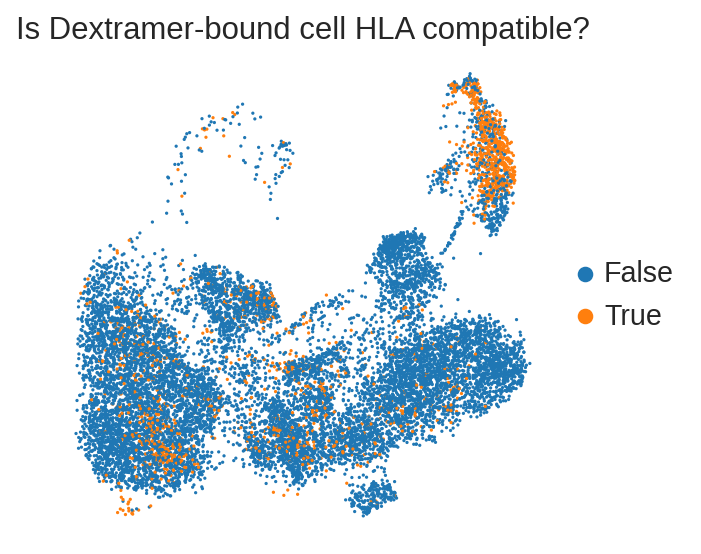

In [43]:
sc.pl.umap(tcr_adata, color='highest_bound_dextramer_matched', frameon=False, show=False, title='Is Dextramer-bound cell HLA compatible?');
# plt.savefig(savedir+'umap_dextramer_matched.pdf')